It reads the path CSV file, extracts locations, and then constructs an adjacency list

In [2]:
import pandas as pd

route_path=pd.read_csv('./path.csv')
locations=route_path['location'].to_list()

adjacency_list={}
for l in locations:
    data=route_path[l].to_list()
    empty_list=[]
    for i in range(len(data)):
        if data[i]==1:
            empty_list.append(locations[i])
    adjacency_list[l]=empty_list
adjacency_list

{'akansha': ['Ecopark', 'shrachi'],
 'Biswa_Bangla': ['dlf2', 'jatragachi', 'Newtown Bus Stand'],
 'cc1': ['Karunamoyee'],
 'cc2': ['shrachi'],
 'Coal India': ['College More', 'Newtown Bus Stand'],
 'College More': ['Coal India', 'Karunamoyee'],
 'dlf2': ['Biswa_Bangla', 'eco-space', 'uem'],
 'eco-space': ['dlf2', 'Westin'],
 'Ecopark': ['akansha', 'Westin'],
 'jatragachi': ['Biswa_Bangla', 'Westin'],
 'Karunamoyee': ['cc1', 'College More'],
 'Newtown Bus Stand': ['Biswa_Bangla', 'Coal India'],
 'shrachi': ['akansha', 'cc2'],
 'uem': ['dlf2'],
 'Westin': ['eco-space', 'Ecopark', 'jatragachi']}

This code loads data for the specific place from a CSV file, retrieves the next possible routes or places based on an adjacency list, and reads distance data from another CSV file.

In [7]:
place_name='Karunamoyee'
place_df=pd.read_csv('./Dataset/'+place_name+'.csv') #we are loading the dataset of the place from where we are tring to find the overspeed

places=adjacency_list[place_name] #It stores the next possible route or places
distance=pd.read_csv('./Distance.csv') #to store the distance dataset

places

['cc1', 'College More']

In [8]:
def find_loc(l,loc):
    c=0
    for i in loc:
        if loc[i] == l:
            return c
        c=c+1
    return c
loc_labels={0: 'akansha',
 1: 'Biswa_Bangla',
 2: 'cc1',
 3: 'cc2',
 4: 'Coal India',
 5: 'College More',
 6: 'dlf2',
 7: 'eco-space',
 8: 'Ecopark',
 9: 'jatragachi',
 10: 'Karunamoyee',
 11: 'Newtown Bus Stand',
 12: 'shrachi',
 13: 'uem',
 14: 'Westin'}

In [9]:
#to check that someone is breaking the rule or not
from datetime import datetime, timedelta

rule_brk=[]

for i in range(0,len(place_df)):
    #print(place_df['Vehicle Number'][i]," ",i)
    veh_no=place_df['Vehicle Number'][i]
    date=place_df['Date'][i]
    time=place_df['Time'][i]
    for plc in places:
        df=pd.read_csv('./Dataset/'+plc+'.csv')
        for srch in range(0,len(df)):
            if veh_no==df['Vehicle Number'][srch] and datetime.strptime(date, "%d-%m-%Y")==datetime.strptime(df['Date'][srch], "%d-%m-%Y"):
                if datetime.strptime(time, '%H:%M:%S') < datetime.strptime(df['Time'][srch], '%H:%M:%S'):
                    dt1 = datetime.strptime(time, "%H:%M:%S")
                    dt2 = datetime.strptime(df['Time'][srch], "%H:%M:%S")
                    time_diff = dt2 - dt1
                    hours_diff = time_diff.total_seconds() / 3600
                    l=find_loc(plc,loc_labels)
                    d=distance[place_name][l]
                    s=d/hours_diff
                    if s>30:
                        print(plc," ",veh_no," ",s,"km/h ",df['Date'][srch])
                        rule_brk.append([veh_no,df['Date'][srch],'Overspeed',plc,time])
    
    

cc1   WB03AB1234   48.0 km/h  13-08-2023
cc1   WB08CD5678   48.0 km/h  13-08-2023
cc1   WB09IJ7890   48.0 km/h  13-08-2023
cc1   WB31BE3001   48.0 km/h  15-10-2023
cc1   WB54AE4009   54.33962264150943 km/h  06-10-2023
cc1   WB12BP2311   48.0 km/h  16-10-2023


In [10]:
rule_brk

[['WB03AB1234', '13-08-2023', 'Overspeed', 'cc1', '10:47:22'],
 ['WB08CD5678', '13-08-2023', 'Overspeed', 'cc1', '16:22:58'],
 ['WB09IJ7890', '13-08-2023', 'Overspeed', 'cc1', '13:07:07'],
 ['WB31BE3001', '15-10-2023', 'Overspeed', 'cc1', '15:44:45'],
 ['WB54AE4009', '06-10-2023', 'Overspeed', 'cc1', '11:15:58'],
 ['WB12BP2311', '16-10-2023', 'Overspeed', 'cc1', '04:42:50']]

In [11]:
#this module is use for uploading the data 
import csv
for i in range(len(rule_brk)):
    overspeed=pd.read_csv('./Overspeed.csv')
    flag=-1
    count=1
    #it is checking if the vehicle is overspeeding in the same place at same date once or more
    for j in range(len(overspeed)):
        v_no=rule_brk[i][0]
        date_no=rule_brk[i][1]
        if v_no==overspeed['Vehicle Number'][j] and rule_brk[i][2]== overspeed['Fine Type'][j] and datetime.strptime(overspeed['Date'][j], "%d-%m-%Y")==datetime.strptime(date_no, "%d-%m-%Y"):
            flag=j
            count = overspeed['Count'][j] + 1
    #It means that the car has broken the rule for first time
    if flag==-1:
        filename = './Overspeed.csv'
        v_data =rule_brk[i][0]
        d_data=rule_brk[i][1]
        with open(filename, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([v_data,d_data,rule_brk[i][4],count,rule_brk[i][3],rule_brk[i][2]])
    else:
        filename = './Overspeed.csv'
        with open(filename, 'r') as file:
            reader = csv.reader(file)
            rows = list(reader)
        rows[flag+1][3]=count
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(rows)

In [12]:
#Dictionary for fine

fine={
    'Overspeed': 500
}

This code establishes a connection to the Gmail SMTP server using the smtplib library, initiates a TLS connection for secure communication, and logs in using the provided sender email and password for authentication.

TLS stands for Transport Layer Security. It's a cryptographic protocol designed to provide secure communication over a computer network.

In [13]:
#To sending Emails.

import smtplib
details=pd.read_csv('./names.csv')
sender_mail='anpr28project@gmail.com'
sender_psswrd='avsgrfhmjritrdxg'
for i in range(len(rule_brk)):
    for det in range(0,len(details)):
        if rule_brk[i][0]==details['Vehicle Number'][det]:
            print("Vehical Number: ",details['Vehicle Number'][det],
                  "\nName: ",details['Name'][det],
                  "\nMobile No: ",details['Mobile'][det],
                  "\nEmail: ",details['Email'][det])
            
            reciever_mail=details['Email'][det] #reciever mail address store
            server = smtplib.SMTP('smtp.gmail.com',587) #Esablish connection
            server.starttls()# Initiates TLS
            server.login(sender_mail,sender_psswrd) #Authenticate credentials
            message = f"Subject: {rule_brk[i][2]} Alert\n\n"
            message += f"Dear {details['Name'][det]},\n\n"
            message += f"We regret to inform you that your vehicle with registration number {details['Vehicle Number'][det]} has been detected exceeding the speed limit at {rule_brk[i][4]}. This violation occurred at {rule_brk[i][3]}. As a consequence, a fine of Rs. {fine[rule_brk[i][2]]} has been charged to your account.\n\n"
            message += f"We urge you to adhere to the specified speed limits for the safety of yourself and others on the road.\n\n"
            message += f"Thank you for your cooperation."

            server.sendmail(sender_mail,reciever_mail,message)
            #print(message)
            print('E-mail sent')

Vehical Number:  WB03AB1234 
Name:  Orion Finch 
Mobile No:  8765432109 
Email:  sagnikb35@gmail.com
E-mail sent
Vehical Number:  WB08CD5678 
Name:  Asher Wilde 
Mobile No:  6543210987 
Email:  siddhanthkmr330@gmail.com
E-mail sent
Vehical Number:  WB09IJ7890 
Name:  Kellan Frost 
Mobile No:  8769012345 
Email:  sneharghasaha07@gmail.com
E-mail sent
Vehical Number:  WB31BE3001 
Name:  Selene Twilight 
Mobile No:  6545678901 
Email:  sahiladgikary25@gmail.com
E-mail sent
Vehical Number:  WB54AE4009 
Name:  Zaina Nova 
Mobile No:  8767890125 
Email:  sahiladgikary25@gmail.com
E-mail sent
Vehical Number:  WB12BP2311 
Name:  Icarus Frost 
Mobile No:  6540123457 
Email:  niladri.khan03@gmail.com
E-mail sent


In [3]:
df = pd.read_csv("./Overspeed.csv")

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') #Converts to datetime format because the value is stored as string

start_date = '2023-08-10'
end_date = '2023-10-15'
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
places_list = filtered_df['Place'].unique().tolist()
places_list

['cc1', 'Newtown Bus Stand', 'eco-space', 'uem', 'dlf2']

In [4]:
filtered_df

,Vehicle Number,Date,Time,Count,Place,Fine Type
0,WB03AB1234,2023-08-13,10:47:22,1,cc1,Overspeed
1,WB08CD5678,2023-08-13,16:22:58,1,cc1,Overspeed
2,WB09IJ7890,2023-08-13,13:07:07,1,cc1,Overspeed
3,WB31BE3001,2023-10-15,15:44:45,1,cc1,Overspeed
4,WB54AE4009,2023-10-06,11:15:58,1,cc1,Overspeed
6,WB78SE5678,2023-10-06,09:21:45,1,Newtown Bus Stand,Overspeed
7,WB38AH9293,2023-08-13,09:25:30,1,eco-space,Overspeed
8,WB22BF6712,2023-08-13,10:55:22,1,eco-space,Overspeed
9,WB14DT3987,2023-08-13,14:30:40,1,eco-space,Overspeed
10,WB09EP7465,2023-08-13,16:05:10,1,eco-space,Overspeed


In [5]:
count = []
for place in places_list:
    cnt = 0
    for index, row in filtered_df.iterrows():
        if row['Place'] == place:
            cnt += row['Count']
    count.append(cnt)
count

[5, 1, 11, 1, 5]

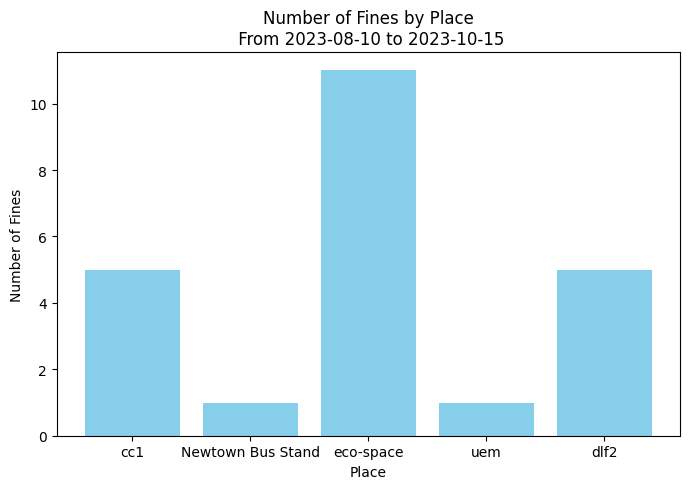

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5)) #width and Height
plt.bar(places_list, count, color='skyBlue') #x y

plt.title(f'Number of Fines by Place\n From {start_date} to {end_date}')
plt.xlabel('Place')
plt.ylabel('Number of Fines')

plt.tight_layout()
plt.show()